<a href="https://colab.research.google.com/github/chunjie-sam-liu/TEP-prognosis/blob/main/analysis/08_AESurv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install torchtuples

     |████████████████████████████████| 51kB 3.6MB/s 


In [4]:
! pip install pycox

     |████████████████████████████████| 81kB 3.9MB/s 


In [140]:
import numpy as np
import feather
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.modules.linear import Linear
import torchtuples as tt

from pycox.models import LogisticHazard
from pycox.models.loss import NLLLogistiHazardLoss
from pycox.evaluation import EvalSurv

import os

In [141]:
# random
np.random.seed(1234)
_ = torch.manual_seed(1234)

In [177]:
class NetAESurv(nn.Module):
    def __init__(self, in_features, encoded_features, out_features):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_features),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoded_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, in_features),
        )

        # Full connection
        self.survnet = nn.Sequential(
            nn.Linear(encoded_features, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, out_features),
        )

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        phi = self.survnet(encoded)
        return phi, decoded

    def predict(self, input):
        encoded = self.encoder(input)
        return self.survnet(encoded)


In [178]:
class LossAELogHaz(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        assert (alpha >= 0) and (alpha <= 1), "Need `alpha` in [0, 1]."
        self.alpha = alpha
        self.loss_surv = NLLLogistiHazardLoss()
        self.loss_ae = nn.MSELoss()

    def forward(self, phi, decoded, target_loghaz, target_ae):
        idx_durations, events = target_loghaz
        loss_surv = self.loss_surv(phi, idx_durations, events)
        loss_ae = self.loss_ae(decoded, target_ae)
        return self.alpha * loss_surv + (1 - self.alpha) * loss_ae


In [179]:
def load_data(filepath):
    df = feather.read_dataframe(source=filepath)
    df_train = df.loc[df.oc == "OC521"].drop(columns=["barcode", "oc"], axis=1)
    df_val = df.loc[df.oc == "OC44"].drop(columns=["barcode", "oc"], axis=1)
    df_test1 = df.loc[df.oc == "OC79"].drop(columns=["barcode", "oc"], axis=1)
    df_test2 = df.loc[df.oc == "OC172"].drop(columns=["barcode", "oc"], axis=1)
    return df_train, df_val, df_test1, df_test2


def get_target(df):
    return (df["duration"].values, df["event"].values)


def transform_features(df_train, df_val, df_test1, df_test2):
    columns = df_train.columns
    columns = columns[: len(columns) - 2]
    standardize = [([col], StandardScaler()) for col in columns]

    x_mapper = DataFrameMapper(standardize)

    x_train = x_mapper.fit_transform(df_train).astype("float32")
    x_val = x_mapper.transform(df_val).astype("float32")
    x_test1 = x_mapper.transform(df_test1).astype("float32")
    x_test2 = x_mapper.transform(df_test2).astype("float32")

    return x_train, x_val, x_test1, x_test2


def transform_labels(df_train, df_val, nd=10):
    num_durations = nd
    labtrans = LogisticHazard.label_transform(num_durations)
    y_train_surv = labtrans.fit_transform(*get_target(df_train))
    y_val_surv = labtrans.transform(*get_target(df_val))

    return y_train_surv, y_val_surv, labtrans


In [180]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [181]:
filepath="/content/drive/MyDrive/colab-data/total416.os.se.norm.feather"

In [182]:
# load data
df_train, df_val, df_test1, df_test2 = load_data(filepath)
# transform features
x_train, x_val, x_test1, x_test2 = transform_features(df_train, df_val, df_test1, df_test2)
# transform labels
y_train_surv, y_val_surv, labtrans = transform_labels(df_train, df_val)

In [148]:
# make train and validation datasets with tuplefy
train = tt.tuplefy(x_train, (y_train_surv, x_train))
val = tt.tuplefy(x_val, (y_val_surv, x_val))

In [183]:
durations_test1, events_test1 = get_target(df_test1)
durations_test2, events_test2 = get_target(df_test2)

In [150]:
# set arch
in_features = x_train.shape[1]
encoded_features = 64
out_features = labtrans.out_features
netaesurv = NetAESurv(in_features, encoded_features, out_features)

In [151]:
netaesurv

NetAESurv(
  (encoder): Sequential(
    (0): Linear(in_features=6636, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=2048, bias=True)
    (9): ReLU()
    (10): Linear(in_features=2048, out_features=6636, bias=True)
  )
  (survnet): Sequ

In [152]:
# loss
loss = LossAELogHaz(0.6)

In [153]:
loss

LossAELogHaz(
  (loss_surv): NLLLogistiHazardLoss()
  (loss_ae): MSELoss()
)

In [154]:
# model
model = LogisticHazard(net=netaesurv, optimizer=tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss=loss)

In [155]:
# metrics
metrics = dict(loss_surv=LossAELogHaz(1), loss_ae=LossAELogHaz(0))

# callbacks
callbacks = [tt.cb.EarlyStopping()]

# cycling
batch_size = 5
epochs = 100

# trainning model
log = model.fit(
    *train, batch_size=batch_size, epochs=epochs,  verbose=True, val_data=val, metrics=metrics
)

0:	[16s / 16s],		train_loss: 573.2497,	train_loss_surv: 1.8015,	train_loss_ae: 1430.4218,	val_loss: 7.1463,	val_loss_surv: 1.3452,	val_loss_ae: 15.8479
1:	[16s / 32s],		train_loss: 2642.8179,	train_loss_surv: 1.6270,	train_loss_ae: 6604.6042,	val_loss: 6.2521,	val_loss_surv: 1.5007,	val_loss_ae: 13.3791
2:	[15s / 48s],		train_loss: 641.7760,	train_loss_surv: 1.2357,	train_loss_ae: 1602.5864,	val_loss: 1.0608,	val_loss_surv: 1.1732,	val_loss_ae: 0.8920
3:	[16s / 1m:4s],		train_loss: 1.0375,	train_loss_surv: 1.0464,	train_loss_ae: 1.0241,	val_loss: 1.0830,	val_loss_surv: 1.2350,	val_loss_ae: 0.8550
4:	[16s / 1m:20s],		train_loss: 1.0343,	train_loss_surv: 1.0504,	train_loss_ae: 1.0101,	val_loss: 1.0883,	val_loss_surv: 1.2476,	val_loss_ae: 0.8493
5:	[16s / 1m:36s],		train_loss: 1.0293,	train_loss_surv: 1.0496,	train_loss_ae: 0.9987,	val_loss: 1.0784,	val_loss_surv: 1.2331,	val_loss_ae: 0.8464
6:	[16s / 1m:53s],		train_loss: 1.0273,	train_loss_surv: 1.0467,	train_loss_ae: 0.9981,	val_loss: 

In [156]:
res = model.log.to_pandas()

In [157]:
res.tail(20)

,train_loss,train_loss_surv,train_loss_ae,val_loss,val_loss_surv,val_loss_ae
80,1.018762,1.030186,1.001627,1.087206,1.249118,0.844338
81,1.015526,1.021468,1.006613,1.096911,1.265211,0.844459
82,1.017409,1.030644,0.997556,1.089468,1.252855,0.844389
83,1.019692,1.031136,1.002526,1.091283,1.255902,0.844354
84,1.017967,1.030169,0.999664,1.084723,1.245006,0.844298
85,1.019879,1.031505,1.002441,1.089880,1.253450,0.844525
86,1.016951,1.025436,1.004225,1.094783,1.261681,0.844436
87,1.015158,1.023721,1.002312,1.090109,1.253832,0.844523
88,1.023070,1.037819,1.000945,1.102024,1.273614,0.844639
89,1.017893,1.030661,0.998741,1.090444,1.254512,0.844342


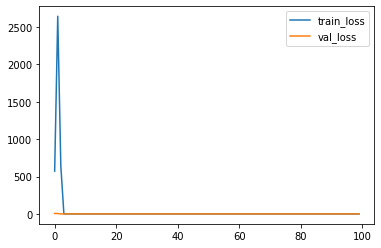

In [158]:
_ = res[['train_loss', 'val_loss']].plot()

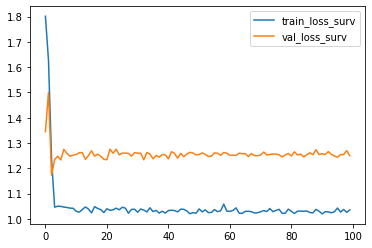

In [159]:
_ = res[['train_loss_surv', 'val_loss_surv']].plot()

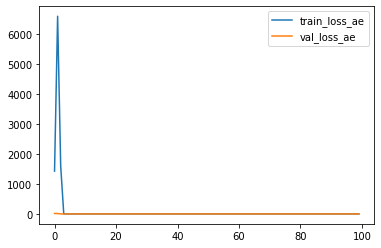

In [160]:
_ = res[['train_loss_ae', 'val_loss_ae']].plot()

In [161]:
surv1 = model.interpolate(10).predict_surv_df(x_test1)
surv2 = model.interpolate(10).predict_surv_df(x_test2)

In [162]:
surv1.iloc[:, :5]

,0,1,2,3,4
0.000000,0.996450,0.996450,0.996450,0.996450,0.996450
1.944444,0.979695,0.979695,0.979695,0.979695,0.979695
3.888889,0.962939,0.962939,0.962939,0.962939,0.962939
5.833333,0.946184,0.946184,0.946184,0.946184,0.946184
7.777778,0.929428,0.929428,0.929428,0.929428,0.929428
...,...,...,...,...,...
167.222222,0.122138,0.122138,0.122138,0.122138,0.122138
169.166667,0.122105,0.122105,0.122105,0.122105,0.122105
171.111111,0.122072,0.122072,0.122072,0.122072,0.122072
173.055556,0.122039,0.122039,0.122039,0.122039,0.122039


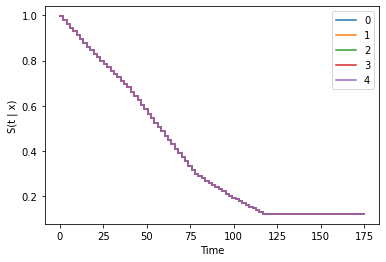

In [163]:
surv2.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [164]:
model.predict(x_test1[:2])

array([[-5.637291  , -1.5987787 , -1.5405307 , -0.91019064, -0.45780593,
        -0.75093687, -0.4325103 , -6.823105  , -5.809291  , -5.912126  ],
       [-5.637291  , -1.5987787 , -1.5405307 , -0.91019064, -0.45780593,
        -0.75093687, -0.4325103 , -6.823105  , -5.809291  , -5.912126  ]],
      dtype=float32)

In [165]:
model.predict_net(x_test1[:2])

(array([[-5.637291  , -1.5987787 , -1.5405307 , -0.91019064, -0.45780593,
         -0.75093687, -0.4325103 , -6.823105  , -5.809291  , -5.912126  ],
        [-5.637291  , -1.5987787 , -1.5405307 , -0.91019064, -0.45780593,
         -0.75093687, -0.4325103 , -6.823105  , -5.809291  , -5.912126  ]],
       dtype=float32),
 array([[-0.00351591,  0.01537065,  0.00248735, ...,  0.01468152,
          0.01230382,  0.00889245],
        [-0.00351591,  0.01537065,  0.00248735, ...,  0.01468152,
          0.01230382,  0.00889245]], dtype=float32))

In [166]:
evs1 = EvalSurv(surv1, durations_test1, events_test1, censor_surv='km')
evs2 = EvalSurv(surv2, durations_test2, events_test2, censor_surv='km')

In [167]:
evs1.concordance_td()

0.5

In [168]:
evs2.concordance_td('antolini')

0.0

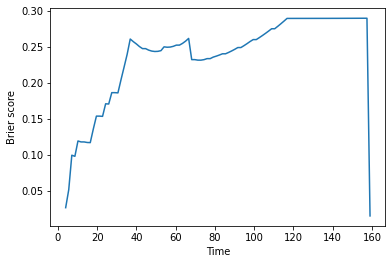

In [169]:
time_grid = np.linspace(durations_test1.min(), durations_test1.max(), 100)
evs1.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

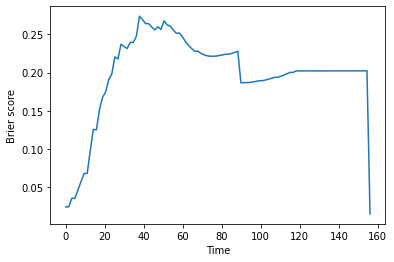

In [170]:
time_grid = np.linspace(durations_test2.min(), durations_test2.max(), 100)
evs2.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

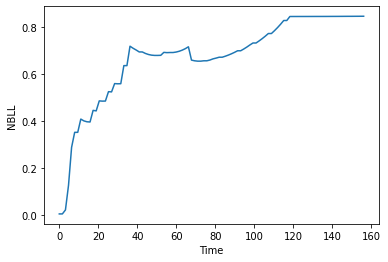

In [171]:
evs1.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

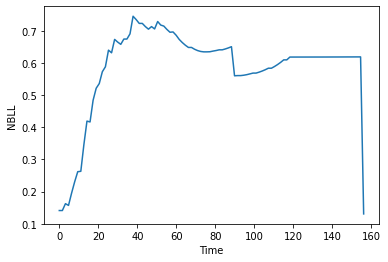

In [172]:
evs2.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [173]:
evs1.integrated_brier_score(time_grid)

0.23276655079011632

In [174]:
evs1.integrated_nbll(time_grid)

0.67328746243737

In [175]:
evs2.integrated_brier_score(time_grid)

0.19939536218433945

In [176]:
evs2.integrated_nbll(time_grid)

0.5894585270334244